In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

# Logistic regression + TF-IDF




In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv("food_ingredients_and_allergens.csv")


df["ingredients_text"] = (
    df["Main Ingredient"].fillna('') + " " +
    df["Sweetener"].fillna('') + " " +
    df["Fat/Oil"].fillna('') + " " +
    df["Seasoning"].fillna('')
)


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df["cleaned_ingredients"] = df["ingredients_text"].apply(clean_text)

df["label"] = df["Prediction"].astype(str).apply(
    lambda x: 1 if x.strip().lower() == "contains" else 0
)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)



final_df = df[["Food Product", "cleaned_ingredients", "label"]]




print(final_df.head())


            Food Product                           cleaned_ingredients  label
0  Cilantro Lime Chicken               chicken olive oil cilantro lime      0
1            Apple Crisp               apple sugar butter cinnamon oat      1
2       Mushroom Risotto  mushroom butter arborio rice parmesan cheese      1
3    Baked Chicken Wings              chicken wing olive oil seasoning      0
4             Baked Brie                          brie cheese herb nut      1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_ingredients"], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
import joblib
joblib.dump(model, 'logistic_regression_model.pkl')
print("Model saved as logistic_regression_model.pkl")

Model saved as logistic_regression_model.pkl


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[21  8]
 [ 0 51]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        29
           1       0.86      1.00      0.93        51

    accuracy                           0.90        80
   macro avg       0.93      0.86      0.88        80
weighted avg       0.91      0.90      0.90        80



In [ ]:
from sklearn.metrics import precision_score


precision = precision_score(y_test, y_pred)

print("Detailed Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Confusion Matrix Counts
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {tn} → correctly predicted 'Does Not Contain'")
print(f"False Positives (FP): {fp} → safe food wrongly flagged as containing allergen")
print(f"False Negatives (FN): {fn} → allergen food missed (should be 0 since Recall=1)")
print(f"True Positives (TP): {tp} → correctly predicted allergen foods")


Detailed Metrics:
Accuracy  : 0.9000
Recall    : 1.0000
Precision : 0.8644
F1-Score  : 0.9273

🔎 Confusion Matrix Breakdown:
   True Negatives (TN): 21 → correctly predicted 'Does Not Contain'
   False Positives (FP): 8 → safe food wrongly flagged as containing allergen
   False Negatives (FN): 0 → allergen food missed (should be 0 since Recall=1)
   True Positives (TP): 51 → correctly predicted allergen foods


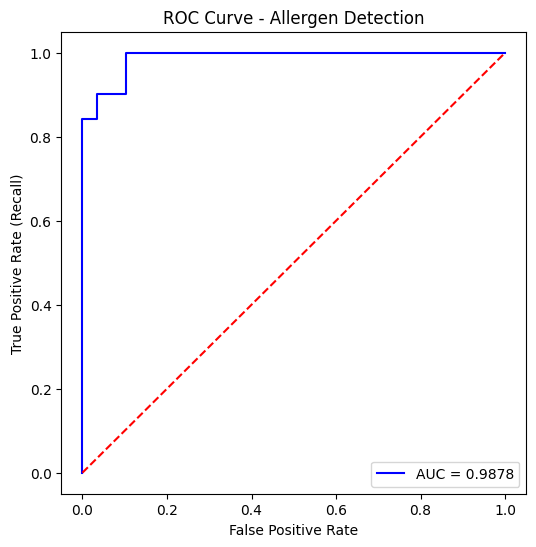

✅ ROC-AUC Score: 0.9878


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities (for ROC curve)
y_probs = model.predict_proba(X_test_tfidf)[:, 1]  # probability of class "1" (Contains)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Allergen Detection")
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC Score: {auc_score:.4f}")


# Fine Tune Bert Model


In [ ]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW

In [ ]:
df = pd.read_csv('food_ingredients_and_allergens.csv')
df.head()

,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Prediction
0,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",Contains
1,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",Contains
2,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",Contains
3,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",Contains
4,Cheddar Cheese,Cheese,NaN,NaN,Salt,Dairy,Contains


In [ ]:



nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv("food_ingredients_and_allergens.csv")


df["ingredients_text"] = (
    df["Main Ingredient"].fillna('') + " " +
    df["Sweetener"].fillna('') + " " +
    df["Fat/Oil"].fillna('') + " " +
    df["Seasoning"].fillna('')
)


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df["cleaned_ingredients"] = df["ingredients_text"].apply(clean_text)

df["label"] = df["Prediction"].astype(str).apply(
    lambda x: 1 if x.strip().lower() == "contains" else 0
)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)



final_df = df[["Food Product", "cleaned_ingredients", "label"]]




print(final_df.head())


            Food Product                           cleaned_ingredients  label
0  Cilantro Lime Chicken               chicken olive oil cilantro lime      0
1            Apple Crisp               apple sugar butter cinnamon oat      1
2       Mushroom Risotto  mushroom butter arborio rice parmesan cheese      1
3    Baked Chicken Wings              chicken wing olive oil seasoning      0
4             Baked Brie                          brie cheese herb nut      1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_ingredients"], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

batch_size=32

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np
import random
import time
from torch.optim import AdamW


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


max_len = 128
encodings = tokenizer(
    df['cleaned_ingredients'].tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='pt'
)

# -------------------------------

X_train_ids, X_test_ids, y_train, y_test = train_test_split(
    encodings['input_ids'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_train_mask, X_test_mask, _, _ = train_test_split(
    encodings['attention_mask'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)


y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)


train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
validation_dataset = TensorDataset(X_test_ids, X_test_mask, y_test_tensor)


batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    validation_dataset,
    sampler=SequentialSampler(validation_dataset),
    batch_size=batch_size
)


model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model = model.to(device)


epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)


def format_time(elapsed):
    return str(time.strftime("%H:%M:%S", time.gmtime(elapsed)))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

training_stats = []
total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    print("Training...")
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        output = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = output.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")


    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )
        loss = output.loss
        total_eval_loss += loss.item()

        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\nTraining complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


Using device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...
  Average training loss: 0.63
  Training epoch took: 00:01:34
Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.53
  Validation took: 00:00:04

======== Epoch 2 / 4 ========
Training...
  Average training loss: 0.50
  Training epoch took: 00:01:15
Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.38
  Validation took: 00:00:04

======== Epoch 3 / 4 ========
Training...
  Average training loss: 0.37
  Training epoch took: 00:01:16
Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.36
  Validation took: 00:00:03

======== Epoch 4 / 4 ========
Training...
  Average training loss: 0.32
  Training epoch took: 00:01:14
Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.29
  Validation took: 00:00:03

Training complete!
Total training took 00:05:38 (h:mm:ss)


In [ ]:

model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")


('bert_model/tokenizer_config.json',
 'bert_model/special_tokens_map.json',
 'bert_model/vocab.txt',
 'bert_model/added_tokens.json')

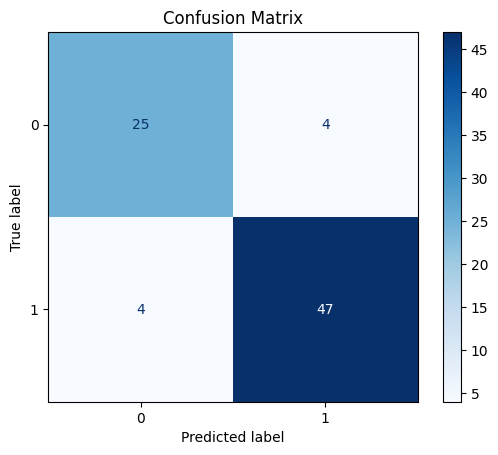

              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86        29
     Class 1       0.92      0.92      0.92        51

    accuracy                           0.90        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.90      0.90      0.90        80



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np


model.eval()

all_preds = []
all_labels = []

for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


In [ ]:

new_text = ["Sugar,Cocoa butter,Milk powder,Vanilla extract"]  #

encoding = tokenizer(
    new_text,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)


model.eval()

with torch.no_grad():
    outputs = model(
        input_ids,
        token_type_ids=None,
        attention_mask=attention_mask
    )

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

print("Predicted label:", predicted_class)


Predicted label: 1
